In [61]:
import cv2
import numpy as np
from scipy import misc
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [62]:
def tograyscale(img):
    return np.dot(img[...,:3], [0.2989, 0.5870, 0.1140])

In [63]:
# caminho relativo
i = mpimg.imread('./images/92.jpg')

In [64]:
i = tograyscale(i)
print(i.shape)

(386, 686)


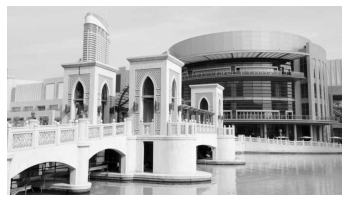

In [65]:
plt.grid(False)
plt.gray()
plt.axis('off')
plt.imshow(i)
plt.show()

In [66]:
filters = [[ [-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], # vertical lines (sobel)
             [ [-1, -2, -1], [0, 0, 0], [1, 2, 1]], # horizontal lines (sobel)
              [ [0, 1, 0], [1, -4, 1], [0, 1, 0]], # edges
              [[0,-1,0],[-1,5,-1],[0,-1,0]], # sharpening
              [[1/9,1/9,1/9],[1/9,1/9,1/9],[1/9,1/9,1/9]], # blur
              [[1/16,2/16,1/16],[2/16,4/16,2/16],[1/16,2/16,1/16]] # gaussian blur 
                ]

In [67]:
# parametros: i = imagem a ser processada, filter = o kernel, weight = a intensidade do filtro, dilatation = dilatação (define o quão afastado estão os pixels 
# vizinhos do pixel pivô)
def singlekernelconvolution(i, filter, weight, dilatation):
  i_filtered = np.copy(i)
  size_x = i_filtered.shape[0]
  size_y = i_filtered.shape[1]

  for x in range(1,size_x-dilatation):
    for y in range(1,size_y-dilatation):
        # pixel x, y é nosso pivô e é ele que acumula a soma dos pixels vizinhos
        pixel = 0.0
        pixel = pixel + (i[x - dilatation, y-dilatation] * filter[0][0])
        pixel = pixel + (i[x, y-dilatation] * filter[0][1])
        pixel = pixel + (i[x + dilatation, y-dilatation] * filter[0][2])
        pixel = pixel + (i[x-dilatation, y] * filter[1][0])
        pixel = pixel + (i[x, y] * filter[1][1])
        pixel = pixel + (i[x+dilatation, y] * filter[1][2])
        pixel = pixel + (i[x-dilatation, y+dilatation] * filter[2][0])
        pixel = pixel + (i[x, y+dilatation] * filter[2][1])
        pixel = pixel + (i[x+dilatation, y+dilatation] * filter[2][2])
        pixel = pixel * weight      
        if(pixel<0):
          pixel=0
        if(pixel>255):
          pixel=255 
        # armazena na nova imagem
        i_filtered[x, y] = pixel
  return i_filtered

conv_outputs = []
# iterando pelos filtros
for f in filters:
  conv_outputs.append(singlekernelconvolution(i, f, 1, 3))

In [8]:
# test=singlekernelconvolution(i, [[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], 1, 1)
# test=singlekernelconvolution(test, [ [-1, -2, -1], [0, 0, 0], [1, 2, 1]], 1, 1)
# plt.grid(False)
# plt.gray()
# plt.axis('off')
# plt.imshow(test)
# plt.show()

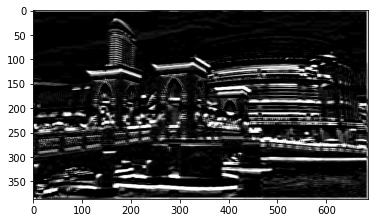

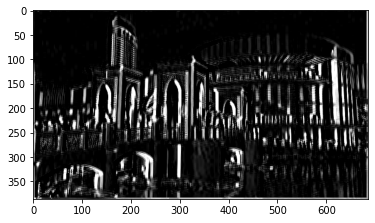

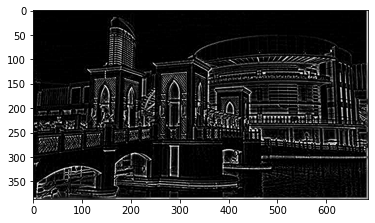

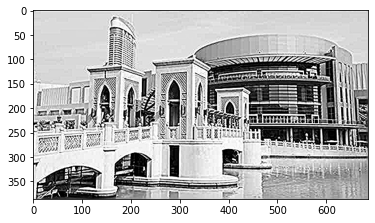

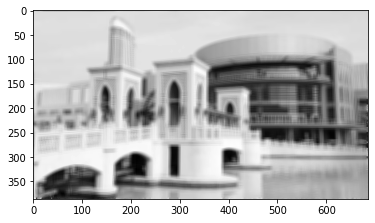

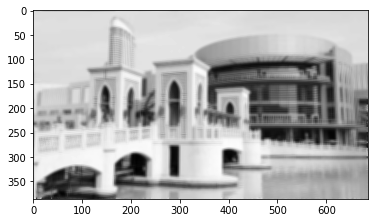

In [59]:
i = 0
for img in conv_outputs:
    plt.gray()
    plt.grid(False)
    #plt.title(str(filters[i]))
    plt.imshow(img)
    plt.show()   
    i += 1

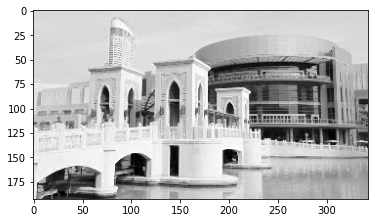

In [18]:

def pooling(i):
  i_transformed = np.copy(i)
  size_x = i_transformed.shape[0]
  size_y = i_transformed.shape[1]
  # novas dimensões da imagem comprimida
  new_x = int(size_x/2)
  new_y = int(size_y/2)
  # cria a matrix que vai receber a imagem comprimida
  newImage = np.zeros((new_x, new_y))
  for x in range(0, size_x, 2):
    for y in range(0, size_y, 2):
      pixels = []
      # analise de uma janela 2x2
      pixels.append(i_transformed[x, y])
      pixels.append(i_transformed[x+1, y])
      pixels.append(i_transformed[x, y+1])
      pixels.append(i_transformed[x+1, y+1])
      # pega o pixel de maior valor
      newImage[int(x/2),int(y/2)] = max(pixels)
  plt.gray()
  plt.grid(False)
  plt.imshow(newImage)
  plt.show()      
    
pooling(i) 

In [19]:
import os

train_dir = './images/train'
validation_dir = './images/validation'

train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

validation_gato_dir = os.path.join(validation_dir, 'cats')
validation_cachorro_dir = os.path.join(validation_dir, 'dogs')

In [30]:
train_cat_fnames = os.listdir( train_cats_dir )
train_dog_fnames = os.listdir( train_dogs_dir )

['cats25265801.jpg']
['dogs5484d9d1eab8ea3017b17e29.jpeg']


In [31]:
# Vamos gerar um modelo apenas para extrair os layers de convolução e analisar
# as imagens produzidas que podem resultar em features uteis
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(4, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(8, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 
    tf.keras.layers.Conv2D(16, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(512, activation='relu'), 
    tf.keras.layers.Dense(1, activation='sigmoid')  
])

model.summary()

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.1),
              loss='binary_crossentropy',
              metrics = ['accuracy'])

# Importante notar as mudanças de dimensoes atraves dos layers, inicialmente temos apenas
# uma imagem 150 x 150, apos aplicação da primeira convolução temos 4 imagens uma para cada
# kernel nas dimensões 148 x 148, a perda de dois pixels em cada dimensão corresponde as fileiras extremas de 
# cada dimensão,
# e os layers de pooling reduzindo pela metade altura e largura

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 148, 148, 4)       112       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 74, 74, 4)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 72, 72, 8)         296       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 36, 36, 8)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 34, 34, 16)        1168      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 17, 17, 16)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 4624)             

In [32]:
# preparando os dataset de validação e treinamento
train_datagen = ImageDataGenerator( rescale = 1.0/255. )
test_datagen  = ImageDataGenerator( rescale = 1.0/255. )
# flow from diretory analisa a estrutura dos diretórios indicados e os separa quanto as n classes para as n pastas de acordo com a seguinte hierarquia
# train_folder
#        |------class_0
#        |------class_1
#        |------class_n
# validation_folder
#        |------class_0
#        |------class_1
#        |------class_n
# bem como em batchs e produz um objeto do tipo generator
train_gen = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(150, 150))     

validation_gen =  test_datagen.flow_from_directory(validation_dir,
                                                         batch_size=20,
                                                         class_mode  = 'binary',
                                                         target_size = (150, 150))

Found 2 images belonging to 2 classes.
Found 2 images belonging to 2 classes.


In [33]:
# treinando o modelo
history = model.fit(train_gen,
                              validation_data=validation_gen,
                              steps_per_epoch=1,
                              epochs=1,
                              validation_steps=5,
                              verbose=2)

1/1 - 1s - loss: 0.7088 - accuracy: 0.5000 - val_loss: 0.6938 - val_accuracy: 0.5000


In [53]:
nrows = 4
ncols = 4

pic_index = 0

In [69]:
import numpy as np
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# vamos definir um novo modelo que vai receber uma imagem como entrada, e vai 
# resultar uma representação intermediaria para cada layer no modelo anterior
# depois do primeiro pegando os objetos do tipo output e input para monta-lo
# o objeto input e o mesmo e os ouputs sao os do modelo anterior
saidas = [layer.output for layer in model.layers[1:]]

for layer in model.layers[1:]:
    print(layer.output)
# com a "API funcional"(um dos dois modos de instanciar um modelo), voce usa os keras.Input 
# objects e layers output objects para para instanciar o modelo definido as dimesões de entrada e saída layer a layer

visualization_model = tf.keras.models.Model(inputs = model.input, outputs = saidas)

KerasTensor(type_spec=TensorSpec(shape=(None, 74, 74, 4), dtype=tf.float32, name=None), name='max_pooling2d_6/MaxPool:0', description="created by layer 'max_pooling2d_6'")
KerasTensor(type_spec=TensorSpec(shape=(None, 72, 72, 8), dtype=tf.float32, name=None), name='conv2d_7/Relu:0', description="created by layer 'conv2d_7'")
KerasTensor(type_spec=TensorSpec(shape=(None, 36, 36, 8), dtype=tf.float32, name=None), name='max_pooling2d_7/MaxPool:0', description="created by layer 'max_pooling2d_7'")
KerasTensor(type_spec=TensorSpec(shape=(None, 34, 34, 16), dtype=tf.float32, name=None), name='conv2d_8/Relu:0', description="created by layer 'conv2d_8'")
KerasTensor(type_spec=TensorSpec(shape=(None, 17, 17, 16), dtype=tf.float32, name=None), name='max_pooling2d_8/MaxPool:0', description="created by layer 'max_pooling2d_8'")
KerasTensor(type_spec=TensorSpec(shape=(None, 4624), dtype=tf.float32, name=None), name='flatten_2/Reshape:0', description="created by layer 'flatten_2'")
KerasTensor(type_

In [55]:
# Escolhemos uma imagen
img_path = './images/train/dogs/dogs5484d9d1eab8ea3017b17e29.jpeg'
img = load_img(img_path, target_size=(150, 150))

/tmp/ipykernel_7372/2595624438.py:29: RuntimeWarning: invalid value encountered in true_divide
  x /= x.std ()


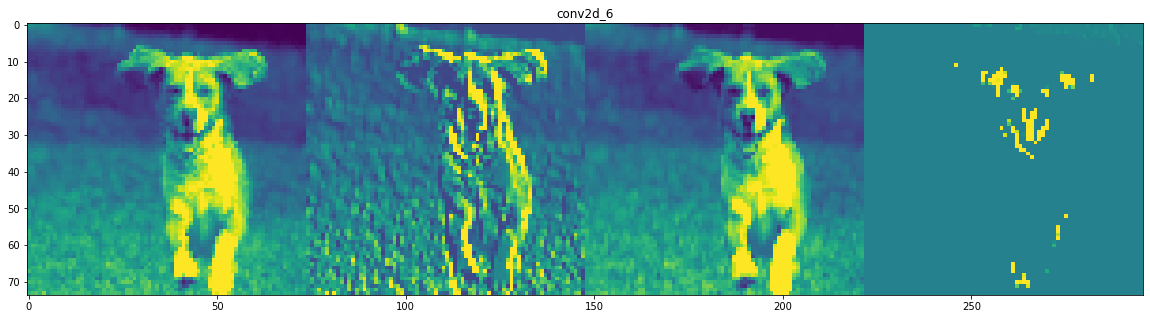

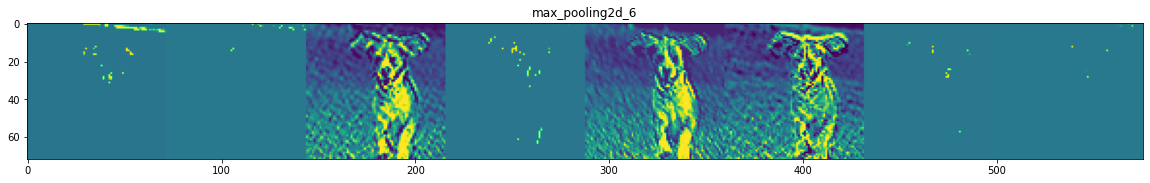

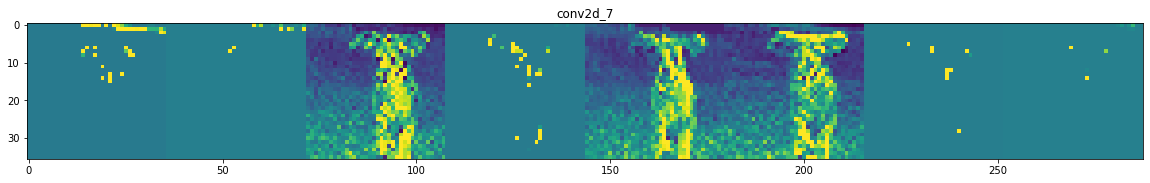

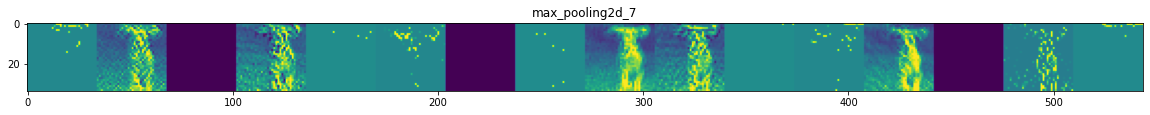

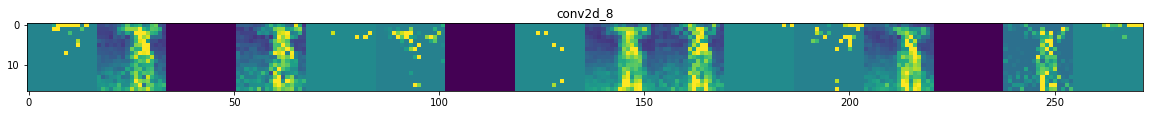

In [56]:

x   = img_to_array(img)
# dando reshape para se adequar o input esperado pelo modelo (1, 150, 150, 3) uma lista de imagens
# 150 x 150 rgb
x   = x.reshape((1,) + x.shape)
x /= 255.0

# passando a imagem pelo modelo 
successive_feature_maps = visualization_model.predict(x)
layer_names = [layer.name for layer in model.layers]


for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:
                                        # numero de imagens
    n_features = feature_map.shape[-1]  # numero de features no feature map (chamamos features cada uma das imgens produzidas pelos kernel por que cada uma tem o potencial de 
                                        # representar alguma caracteristica importante da imagem)
    size       = feature_map.shape[ 1]  # dimensões feature map (1, size, size, n_features)
    
    # preparando o grid de imagens para o pyplot
    display_grid = np.zeros((size, size * n_features))
    
    # após a aplicação dos kernel podem apresentar valores fora dos intervalos normais para uma imagem fazendo sentido para o modelo mais não para nossa vizualização
    for i in range(n_features): # loop pelas imagens da linha atual
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std () # normaliza
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8') # traz todos os valores da imagem para dentro do intervalo 0-255
      display_grid[:, i * size : (i + 1) * size] = x # grade das imagens

    # rederiza usando pyplot
    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis' ) 

In [ ]:
import numpy as np

# função de ativação
def sigmoid(x):
    return 1/(1+np.exp(-x))
# derivada da função de ativação
def sigmoid_der(x):
    return sigmoid(x)*(1-sigmoid(x))

training_set = np.array([[1,1,1,1],[0,0,1,0],[1,0,0,0],[0,1,0,0],[1,1,1,0],[0,0,1,1],[0,1,1,0],[0,1,1,1]]) # batch
labels = np.array([[1,0,0,0,1,0,0,1]])
labels = labels.reshape(8,1)

# Os pesos e o bias sao iniciados com valores randomicos
np.random.seed(42)
weights = np.random.rand(4,1)
bias = np.random.rand(1) # para deslocamento apartir da origem
lr = 0.05
i=0
for epoch in range(20000):
    XW = []
    # feedforward step1 ()
    # machine learning is 99% dot product -musk, elon
    for input in training_set:
        XW.append(np.dot(input, weights) + bias) # soma dos inputs e pesos na forma do 
                                                 # produto interno das matrizes

    #feedforward step2
    z=[]
    for input in XW:
        z.append(sigmoid(input)) # função de ativação
    z = np.array(z)

    # backpropagation step 1
    error = z - labels # calculo do erro ou desvio medio
    
    print('epoch '+str(i)+' : '+str(error.sum()/len(error)))
    i+=1
    # backpropagation step 2 - calculo dos ajustes
    dcost_dpred = error 
    dpred_dz = sigmoid_der(z) 

    z_delta = dcost_dpred * dpred_dz # 

    inputs = training_set.T
    weights -= lr * np.dot(inputs, z_delta) # atualiza os pesos com base no valor da derivada
                                            # e na taxa de aprendizagem
    for num in z_delta:
        bias -= lr * num


In [ ]:
print('======= weight matrix =======')
print(weights)
print('# bias = '+str(bias))
print('=============================')

test_set = [[0,1,1,1],[1,0,1,1], [1,0,0,0]]
for input in test_set:
    single_point = np.array(input)
    result = sigmoid(np.dot(single_point, weights) + bias)
    print(result)